This notebook helps to learn how to build a basic image classification system from scratch, and progressively improve it using higher levels of abstraction and finally using the learner module in fastai. We choose a problem that is similar to MNIST digit classification, but slightly different to allow a deeper understanding of building an end-to-end solution on a "not-so-familiar" dataset. The model has to classify handwritten music symbol image into one of the 5 classes namely whole note, half note, quarter note, eighth note and sixteenth note. 

In [1]:
from fastai.vision.all import *
from fastbook import *

In [2]:
dataset_path = Path('/home/jobin/exploration/datasets/NotesDataset/Notes')

In [3]:
## start with simple problem => 2 class problem to differentiate half note from quarter note ##
quarters = (dataset_path/'Quarter').ls().sorted()
halfs = (dataset_path/'Half').ls().sorted()

In [4]:
quarters[0],halfs[0]

(Path('/home/jobin/exploration/datasets/NotesDataset/Notes/Quarter/q1.jpg'),
 Path('/home/jobin/exploration/datasets/NotesDataset/Notes/Half/h1.jpg'))

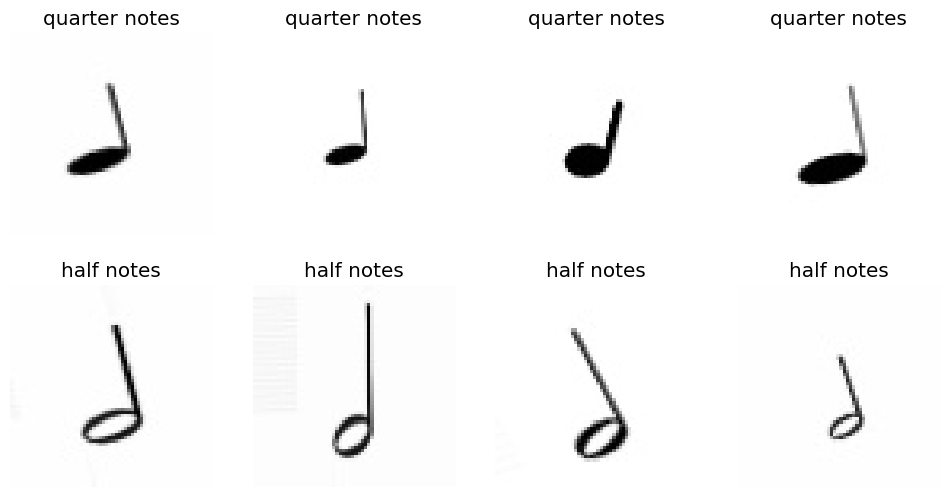

In [5]:
## show some samples
_,axs = plt.subplots(nrows=2,ncols=4, figsize=(12,6))
for i in range(4):
    show_image(Image.open(quarters[i]),title='quarter notes',ax=axs[0][i])
    show_image(Image.open(halfs[i]),title='half notes',ax=axs[1][i])

In [6]:
## load into a tensor and see how it looks ##
quarter_tens = tensor(Image.open(quarters[0]).convert('L')) ## convert to grey scale - original has RGB 
quarter_tens.shape ## each input is now a 64X64 grey-scale image

torch.Size([64, 64])

In [7]:
## plot a portion ##
df = pd.DataFrame(quarter_tens[15:55,15:45])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,254,254,254,254,254,254,254,254,254,254,255,254,253,253,253,248,242,253,253,253,254,254,254,254,254,254,254,254,254,254
1,254,254,254,254,254,254,254,254,254,254,254,254,251,254,252,198,132,206,252,254,253,251,255,254,254,254,254,254,254,254
2,254,254,254,254,254,254,254,254,254,255,255,254,255,254,244,184,74,136,251,255,255,255,253,254,255,254,254,254,254,254
3,254,254,254,254,254,254,254,254,254,253,253,251,254,254,255,224,89,76,255,254,250,254,255,255,252,254,254,254,254,254
4,254,254,254,254,254,254,254,254,254,255,255,255,253,251,254,245,115,46,237,254,254,252,255,253,255,254,254,254,254,254
5,254,254,254,254,254,254,254,254,254,253,254,255,255,255,255,252,150,58,184,252,255,255,254,251,255,254,254,254,254,254
6,254,254,254,254,254,254,254,254,254,254,254,253,251,253,252,250,192,80,123,255,253,255,252,254,253,254,254,254,254,254
7,254,254,254,254,254,254,254,254,254,253,255,254,255,255,253,253,230,91,71,252,255,253,253,255,255,254,254,254,254,254
8,254,254,254,254,254,254,254,254,254,253,255,251,254,253,253,255,248,123,45,227,253,252,255,251,254,254,254,254,254,254
9,254,254,254,254,254,254,254,254,254,254,254,254,254,254,254,253,252,158,66,171,252,255,252,255,254,254,254,254,254,254


## approach-1 => simple pattern matching ##
1. load all half-notes into a tensor and calculate "avergae" half-note image
2. Load all quarter-notes into a tensor and calculate "avergae" quarter-note image
3. for any incoming image, check distance between the "average" images and predict the class as the one corresponding to the one which is "closer"

In [8]:
half_tensor = torch.stack([tensor(Image.open(img).convert('L')) for img in halfs])/255.0
quarter_tensor = torch.stack([tensor(Image.open(img).convert('L')) for img in quarters])/255.0

In [9]:
half_tensor.shape,quarter_tensor.shape

(torch.Size([1000, 64, 64]), torch.Size([1000, 64, 64]))

<Axes: title={'center': 'quarter'}>

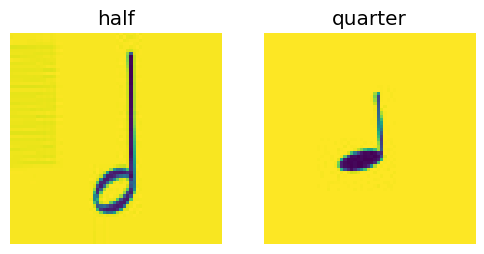

In [10]:
## show some plot of single channel image
_,axs = plt.subplots(nrows=1,ncols=2,figsize=(6,3))
show_image(half_tensor[1],title='half',ax=axs[0])
show_image(quarter_tensor[1],title='quarter',ax=axs[1])

In [11]:
mean_halfnote = half_tensor.mean(dim=0)
mean_quarternote = quarter_tensor.mean(dim=0)

<Axes: title={'center': 'mean quarter-note'}>

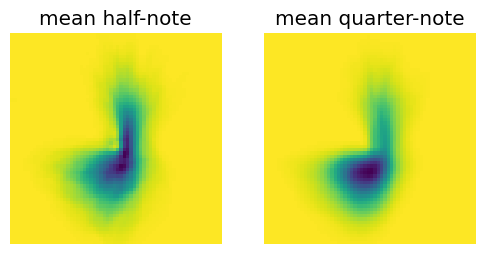

In [12]:
_,axs = plt.subplots(1,2,figsize=(6,3))
show_image(mean_halfnote,title='mean half-note',ax=axs[0])
show_image(mean_quarternote,title='mean quarter-note',ax=axs[1])

In [13]:
query_image = quarter_tensor[-1]

In [14]:
## compute l1-distance between query image and mean image, and predict the class ##
F.l1_loss(query_image,mean_quarternote),F.l1_loss(query_image,mean_halfnote)

(tensor(0.0594), tensor(0.0634))

In [15]:
def is_quarter_note(img_tensor):
    return F.l1_loss(img_tensor,mean_quarternote) < F.l1_loss(img_tensor,mean_halfnote)

In [16]:
is_quarter_note(query_image)

tensor(True)

### evaluate the baseline in a formal way ###
1. split data into train and test
2. learn the "mean" images from train split
3. use the classification function is_quarter_note to calculate accuracy

In [17]:
train_split_percent = 0.8
train_halfnote_x = half_tensor[:int(len(half_tensor)*train_split_percent)]
valid_halfnote_x = half_tensor[int(len(half_tensor)*train_split_percent):]

train_quarternote_x = quarter_tensor[:int(len(quarter_tensor)*train_split_percent)]
valid_quarternote_x = quarter_tensor[int(len(quarter_tensor)*train_split_percent):]

In [18]:
train_halfnote_x.shape,train_quarternote_x.shape,valid_halfnote_x.shape,valid_quarternote_x.shape

(torch.Size([800, 64, 64]),
 torch.Size([800, 64, 64]),
 torch.Size([200, 64, 64]),
 torch.Size([200, 64, 64]))

In [19]:
mean_quarternote = train_quarternote_x.mean(0)
mean_halfnote = train_halfnote_x.mean(0)

In [20]:
def image_distance(a,b): 
    return (a-b).abs().mean((-1,-2))

def is_quarter_note(img_tensor):
    return image_distance(img_tensor,mean_quarternote) < image_distance(img_tensor,mean_halfnote)

In [21]:
accuracy_quarter = is_quarter_note(valid_quarternote_x).float() .mean()
accuracy_half = (1.0 - is_quarter_note(valid_halfnote_x).float()).mean()

In [22]:
print(f'accuracy of quarter note={accuracy_quarter},accuracy of half note={accuracy_half},\
overall acc={(accuracy_quarter+accuracy_half)/2}')

accuracy of quarter note=0.29499998688697815,accuracy of half note=1.0,overall acc=0.6474999785423279


In [23]:
## 64.7 is not a very great accuracy;especially it cannot recognize quarter notes correctly##


### lets try an off-the-shelf vision learner from fastai to see what is possible ##
1. simply load images from two directories using a fastai dataloader
2. use a vision learner and a pretrained off-the-shelf model like resnet
3. see what kind of accuracy can be obtained by simple finetuning (note data is loaded as RGB in this case)

In [226]:
## prepare a dataloader#
dataset_path

Path('/home/jobin/exploration/datasets/NotesDataset/Notes')

In [227]:
classes = ['Quarter','Half']

In [228]:
dataset_path.ls()

(#5) [Path('/home/jobin/exploration/datasets/NotesDataset/Notes/Quarter'),Path('/home/jobin/exploration/datasets/NotesDataset/Notes/Eight'),Path('/home/jobin/exploration/datasets/NotesDataset/Notes/Sixteenth'),Path('/home/jobin/exploration/datasets/NotesDataset/Notes/Whole'),Path('/home/jobin/exploration/datasets/NotesDataset/Notes/Half')]

In [229]:
## selectively filter only two classes as we want to model this first as a binary classification problem ##
def filter_items_from_folders(path,folders):
    return get_image_files(path).filter(lambda x:x.parent.name in folders)

In [230]:
lst = filter_items_from_folders(dataset_path,classes)
print(f'total files={len(lst)}')

total files=2000


In [231]:
dls = ImageDataLoaders.from_lists(dataset_path, 
                                  fnames=quarters+halfs,
                                  labels = ['Quarter']*len(quarters) + ['Half']*len(halfs),
                                  valid_pct = 0.2,
                                  seed = 42
                                  )                                     

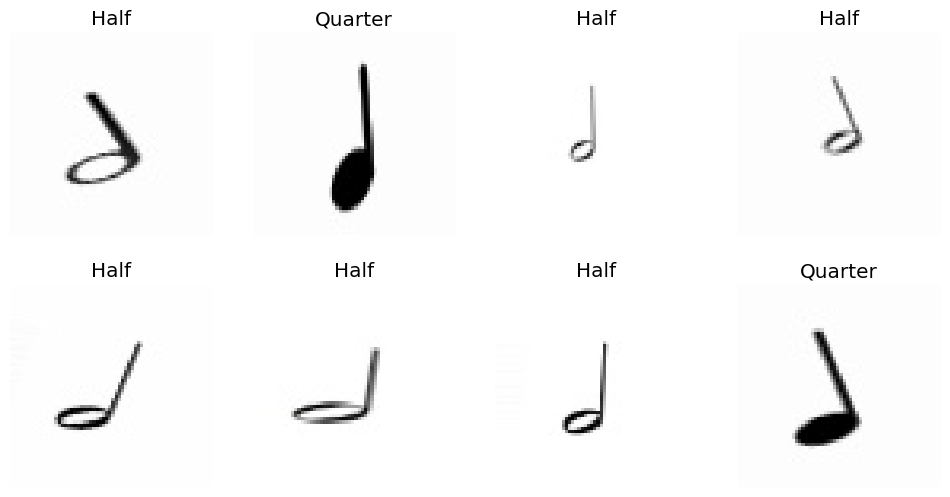

In [232]:
dls.show_batch(nrows=2,ncols=4)

In [233]:
pretrained_learner = vision_learner(dls,resnet18,loss_func=F.cross_entropy,metrics=accuracy)

In [234]:
pretrained_learner.fine_tune(3)

epoch,train_loss,valid_loss,accuracy,time
0,0.543430,0.261511,0.900000,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.066948,0.150218,0.947500,00:01
1,0.047020,0.001408,1.000000,00:01
2,0.025387,0.000909,1.000000,00:01


### this means an off-the-shelf vision model can easily solve this task ###
Why did our baseline work very poorly?
1. we combined RGB channels into one to create 64x64 images while loading data in the baseline => information loss?
2. may be we are using a wrong distance metric when comparing with the average image?
3. pretrained resent is quite powerful in its feature extraction already..so classifying these images is quite an easy task for the model

In [23]:
## try flattening the image to retain full data to see if our hypothesis #1 is true ##

In [24]:
quarter_tens = tensor(Image.open(quarters[0]))
quarter_tens.shape

torch.Size([64, 64, 3])

In [35]:
## load flattened data and repeat approach-1 ##

half_tensor = torch.stack([tensor(Image.open(img)).flatten() for img in halfs])/255.0
quarter_tensor = torch.stack([tensor(Image.open(img)).flatten() for img in quarters])/255.0

In [37]:
quarter_tensor.shape

torch.Size([1000, 12288])

<Axes: title={'center': 'quarter'}>

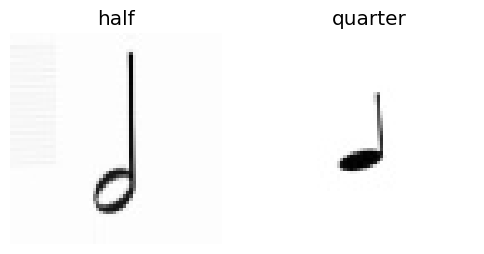

In [38]:
## show some plot of single channel image
_,axs = plt.subplots(nrows=1,ncols=2,figsize=(6,3))
show_image(half_tensor[1].view(64,64,3),title='half',ax=axs[0])
show_image(quarter_tensor[1].view(64,64,3),title='quarter',ax=axs[1])

In [39]:
mean_halfnote = half_tensor.mean(dim=0)
mean_quarternote = quarter_tensor.mean(dim=0)

<Axes: title={'center': 'mean quarter-note'}>

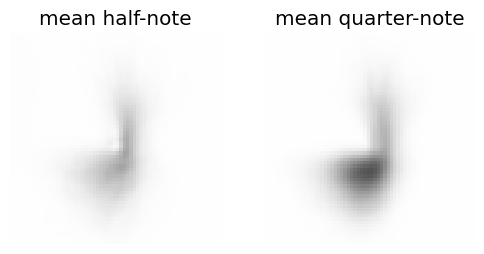

In [41]:
_,axs = plt.subplots(1,2,figsize=(6,3))
show_image(mean_halfnote.view(64,64,3),title='mean half-note',ax=axs[0])
show_image(mean_quarternote.view(64,64,3),title='mean quarter-note',ax=axs[1])

In [42]:
query_image = quarter_tensor[-1]

In [43]:
## compute l1-distance between query image and mean image, and predict the class ##
F.l1_loss(query_image,mean_quarternote),F.l1_loss(query_image,mean_halfnote)

(tensor(0.0594), tensor(0.0634))

In [46]:
train_split_percent = 0.8
train_halfnote_x = half_tensor[:int(len(half_tensor)*train_split_percent)]
valid_halfnote_x = half_tensor[int(len(half_tensor)*train_split_percent):]

train_quarternote_x = quarter_tensor[:int(len(quarter_tensor)*train_split_percent)]
valid_quarternote_x = quarter_tensor[int(len(quarter_tensor)*train_split_percent):]

In [47]:
train_halfnote_x.shape,train_quarternote_x.shape,valid_halfnote_x.shape,valid_quarternote_x.shape

(torch.Size([800, 12288]),
 torch.Size([800, 12288]),
 torch.Size([200, 12288]),
 torch.Size([200, 12288]))

In [48]:
mean_quarternote = train_quarternote_x.mean(0)
mean_halfnote = train_halfnote_x.mean(0)

In [102]:
def image_distance(a,b): 
    return (a-b).abs().mean(-1)

def is_quarter_note(img_tensor):
    return image_distance(img_tensor,mean_quarternote) < image_distance(img_tensor,mean_halfnote)

In [54]:
accuracy_quarter = is_quarter_note(valid_quarternote_x).float() .mean()
accuracy_half = (1.0 - is_quarter_note(valid_halfnote_x).float()).mean()

In [55]:
print(f'accuracy of quarter note={accuracy_quarter},accuracy of half note={accuracy_half},\
overall acc={(accuracy_quarter+accuracy_half)/2}')

accuracy of quarter note=0.29499998688697815,accuracy of half note=1.0,overall acc=0.6474999785423279


<Axes: title={'center': 'mean quarter-note'}>

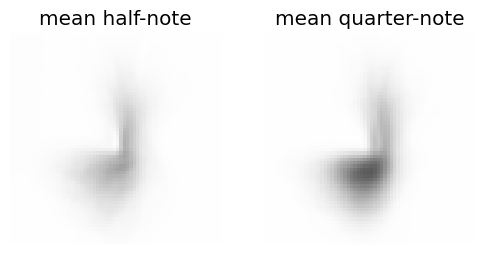

In [52]:
_,axs = plt.subplots(1,2,figsize=(6,3))
show_image(mean_halfnote.view(64,64,3),title='mean half-note',ax=axs[0])
show_image(mean_quarternote.view(64,64,3),title='mean quarter-note',ax=axs[1])

In [59]:
image_distance(valid_quarternote_x[0],mean_quarternote),image_distance(valid_quarternote_x[0],mean_halfnote)

(tensor(0.0466), tensor(0.0419))

In [63]:
is_quarter_note(valid_halfnote_x)[:10]

tensor([False, False, False, False, False, False, False, False, False, False])

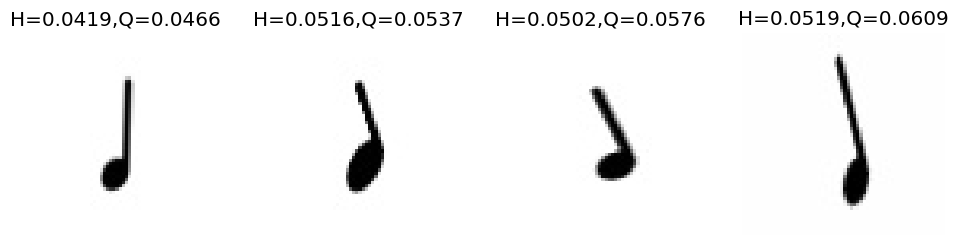

In [78]:
## plot few errors in quarter notes##
_, axs = plt.subplots(nrows=1,ncols=4,figsize=(12,3))
for i in range(4):
    qtr_dist= np.round(image_distance(valid_quarternote_x[i],mean_quarternote),4).numpy()
    hlf_dist= np.round(image_distance(valid_quarternote_x[i],mean_halfnote),4).numpy()
    show_image(valid_quarternote_x[i].view(64,64,3),title=f'H={str(hlf_dist)},Q={str(qtr_dist)}',ax=axs[i])

## the distances seem to indicate these are closer to half note, which is incorrect.
## So problem is likely with the distance metric => change to consie and see the effect

In [103]:
def is_quarter_note_consine(img_tensor):
    return F.cosine_similarity(img_tensor,mean_quarternote.unsqueeze(0)) > F.cosine_similarity(img_tensor,mean_halfnote.unsqueeze(0))

In [114]:
accuracy_quarter = np.round(is_quarter_note_consine(valid_quarternote_x).float() .mean().numpy(),4)
accuracy_half = np.round((1.0 - is_quarter_note_consine(valid_halfnote_x).float()).mean().numpy(),4)

In [128]:
print(f'accuracy of quarter note={str(accuracy_quarter)},accuracy of half note={str(accuracy_half)},\
overall acc={str(round((accuracy_quarter+accuracy_half)/2,2))}')

accuracy of quarter note=0.71,accuracy of half note=0.93,overall acc=0.82


In [129]:
## turns out the distance metric was the issue, cosine distance is giving 82% accuracy without any real "training" ##
## so the problem is not very complex, or loading single channel data insted of RGB is not causing information loss ##

### try a simple one-layer neural network model using SGD ###

In [8]:
halfs,quarters

((#1000) [Path('/home/jobin/exploration/datasets/NotesDataset/Notes/Half/h1.jpg'),Path('/home/jobin/exploration/datasets/NotesDataset/Notes/Half/h10.jpg'),Path('/home/jobin/exploration/datasets/NotesDataset/Notes/Half/h100.jpg'),Path('/home/jobin/exploration/datasets/NotesDataset/Notes/Half/h1000.jpg'),Path('/home/jobin/exploration/datasets/NotesDataset/Notes/Half/h101.jpg'),Path('/home/jobin/exploration/datasets/NotesDataset/Notes/Half/h102.jpg'),Path('/home/jobin/exploration/datasets/NotesDataset/Notes/Half/h103.jpg'),Path('/home/jobin/exploration/datasets/NotesDataset/Notes/Half/h104.jpg'),Path('/home/jobin/exploration/datasets/NotesDataset/Notes/Half/h105.jpg'),Path('/home/jobin/exploration/datasets/NotesDataset/Notes/Half/h106.jpg')...],
 (#1000) [Path('/home/jobin/exploration/datasets/NotesDataset/Notes/Quarter/q1.jpg'),Path('/home/jobin/exploration/datasets/NotesDataset/Notes/Quarter/q10.jpg'),Path('/home/jobin/exploration/datasets/NotesDataset/Notes/Quarter/q100.jpg'),Path('/ho

In [9]:
half_tensor = torch.stack([tensor(Image.open(img).convert('L')) for img in halfs])/255.0
quarter_tensor = torch.stack([tensor(Image.open(img).convert('L')) for img in quarters])/255.0

In [10]:
half_tensor.shape,quarter_tensor.shape

(torch.Size([1000, 64, 64]), torch.Size([1000, 64, 64]))

In [17]:
train_split_percent = 0.8
train_halfnote_x = half_tensor[:int(len(half_tensor)*train_split_percent)]
valid_halfnote_x = half_tensor[int(len(half_tensor)*train_split_percent):]

train_quarternote_x = quarter_tensor[:int(len(quarter_tensor)*train_split_percent)]
valid_quarternote_x = quarter_tensor[int(len(quarter_tensor)*train_split_percent):]

In [18]:
train_halfnote_x.shape,train_quarternote_x.shape

(torch.Size([800, 64, 64]), torch.Size([800, 64, 64]))

In [23]:
train_x = torch.cat([train_quarternote_x, train_halfnote_x]).view(-1, 64*64) ## flatten
valid_x = torch.cat([valid_quarternote_x, valid_halfnote_x]).view(-1, 64*64)

In [24]:
train_y = tensor([1]*len(train_quarternote_x) + [0]*len(train_halfnote_x)).unsqueeze(1)
valid_y = tensor([1]*len(valid_quarternote_x) + [0]*len(valid_halfnote_x)).unsqueeze(1)
train_x.shape,train_y.shape,valid_x.shape,valid_y.shape
## quarter note => 1, half note => 0

(torch.Size([1600, 4096]),
 torch.Size([1600, 1]),
 torch.Size([400, 4096]),
 torch.Size([400, 1]))

In [25]:
## put together a dataset
train_dset = list(zip(train_x,train_y)) 
valid_dset = list(zip(valid_x,valid_y))

In [57]:
def init_params(size, std=1.0):
    return (torch.randn(size)*std).requires_grad_()

In [58]:
weights = init_params((64*64,1))
bias = init_params(1)
weights.shape, bias.shape

(torch.Size([4096, 1]), torch.Size([1]))

<Axes: title={'center': 'initial weights'}>

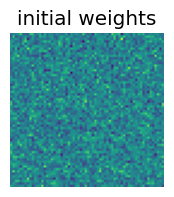

In [59]:
show_image(weights.view(64,64),title='initial weights')

In [139]:
## define a simple linear model
def linear_model(xb): 
    return xb@weights + bias

## define a loss function
def loss_function(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

In [153]:
## prepare a dataloader with a batch size of 32
train_dl = DataLoader(train_dset, batch_size=32,shuffle=True)
valid_dl = DataLoader(valid_dset, batch_size=32,shuffle=True)
xb,yb = first(train_dl)
xb.shape,yb.shape

(torch.Size([32, 4096]), torch.Size([32, 1]))

In [154]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = loss_function(preds, yb)
    loss.backward()

In [155]:
def train_epoch(model, lr, params):
    for xb,yb in train_dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

In [156]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

In [157]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [158]:
validate_epoch(linear_model) ## this will ofcourse be poor now as weights are just random currently

0.4976

In [159]:
## train it now
lr = 0.01
params = weights,bias
for i in range(20):
    train_epoch(linear_model, lr, params)
    print(validate_epoch(linear_model), end=' ')

0.5024 0.5024 0.4976 0.4952 0.5024 0.5 0.5096 0.4976 0.5 0.5096 0.4952 0.4976 0.4976 0.5 0.5 0.5048 0.4928 0.4976 0.4928 0.5 

In [160]:
## we do this basic model using fastai ##
dls = DataLoaders(train_dl, valid_dl)

In [161]:
learn = Learner(dls, nn.Linear(64*64,1), opt_func=SGD,
                loss_func=loss_function, metrics=batch_accuracy)

In [162]:
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.495907,0.467093,0.500000,00:00
1,0.464623,0.455152,0.500000,00:00
2,0.438211,0.336393,0.815000,00:00
3,0.413866,0.402636,0.550000,00:00
4,0.392073,0.280446,0.805000,00:00
5,0.366558,0.355032,0.632500,00:00
6,0.349152,0.317868,0.687500,00:00
7,0.334695,0.234978,0.855000,00:00
8,0.327695,0.228114,0.832500,00:00
9,0.312899,0.227439,0.817500,00:00


In [166]:
### now make the model more complex with multi-layer and non-linearity ##
simple_net = nn.Sequential(
    nn.Linear(64*64,30),
    nn.ReLU(),
    nn.Linear(30,1),
  )

In [168]:
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=loss_function, metrics=batch_accuracy)

In [169]:
learn.fit(15, lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.497709,0.484492,0.500000,00:00
1,0.488123,0.470760,0.500000,00:00
2,0.480171,0.440724,0.667500,00:00
3,0.460337,0.424077,0.500000,00:00
4,0.441831,0.389004,0.705000,00:00
5,0.422760,0.355177,0.732500,00:00
6,0.402382,0.318969,0.860000,00:00
7,0.383111,0.306024,0.767500,00:00
8,0.365149,0.295217,0.752500,00:00
9,0.351575,0.254595,0.820000,00:00


In [221]:
q_note_preds = learn.model(valid_quarternote_x.view(-1,64*64)).cpu()
half_note_preds = learn.model(valid_halfnote_x.view(-1,64*64)).cpu()

In [224]:
accuracy_quarter = (q_note_preds.detach()>0).squeeze().float().mean().numpy()
accuracy_half= (half_note_preds.detach()<0).squeeze().float().mean().numpy()

In [225]:
print(f'accuracy of quarter note={str(accuracy_quarter)},accuracy of half note={str(accuracy_half)},\
overall acc={str(round((accuracy_quarter+accuracy_half)/2,2))}')

accuracy of quarter note=0.735,accuracy of half note=0.945,overall acc=0.84


In [275]:
## COSINE baseline => accuracy of quarter note=0.71,accuracy of half note=0.93,overall acc=0.82

In [276]:
### check by copying the single channel data as RGB to see the effect of using full image data vs. using greyscale ###
pretrained_learner.dls.vocab
valid_q_notes_cuda = (torch.stack([valid_quarternote_x,valid_quarternote_x,valid_quarternote_x],1)*1.0).to('cuda')
q_note_preds = pretrained_learner.model(valid_q_notes_cuda)[:,1].cpu()

valid_half_notes_cuda = (torch.stack([valid_halfnote_x,valid_halfnote_x,valid_halfnote_x],1)*1.0).to('cuda')
half_note_preds = pretrained_learner.model(valid_half_notes_cuda)[:,0].cpu()

#half_note_preds = pretrained_learner.model(valid_halfnote_x).cpu()

In [277]:
accuracy_quarter = (q_note_preds.detach()>0).squeeze().float().mean().numpy()
accuracy_half = (half_note_preds.detach()<0).squeeze().float().mean().numpy()

In [278]:
accuracy_quarter,accuracy_half

(array(0.875, dtype=float32), array(0.99, dtype=float32))

In [279]:
print(f'accuracy of quarter note={str(accuracy_quarter)},accuracy of half note={str(accuracy_half)},\
overall acc={str(round((accuracy_quarter+accuracy_half)/2,2))}')

accuracy of quarter note=0.875,accuracy of half note=0.99,overall acc=0.93


### Learnings ###
1. adding a RELU non-linearity is improving the performance. But only 2% improvment from the consine distance based simple baseline. So, simple neural network is not doing that great in this problem. 
2. CNN architectures and pre-training gives a huge advantage as we see in resnet-18 results, getting almost a perfect score (loading RGB data is also a factor here)
3. Even if we use just one channel data, the pre-trained model gives good performance. The lower performance compared to the case with RGB data is because original ResNets are trained by using this data